In [20]:
import numpy as np
import matplotlib.pyplot as plt
from load import load_daily_generation_data
import datetime

## Load and format data

In [19]:
data = load_daily_generation_data('.\Data\gen_2021.csv')
day_of_week = np.array([ts.weekday() for ts in data['timestamps']])
datetimes = np.array([datetime.datetime.combine(
    date, datetime.time(1, 1)) for date in data['timestamps']])


In [25]:
def normalize_series(series, normalization_const = None):
    series = np.array(series).reshape(-1, 1)
    series_min = np.min(series)
    if not normalization_const:
        normalization_const = np.max(series) - series_min
    return (series - series_min)/normalization_const

In [39]:
x = np.concatenate((normalize_series(datetimes), normalize_series(day_of_week)), axis=1)
y_renewables = normalize_series(data['renewables'])
y_non_renewables = normalize_series(data['non_renewables'])

## Train model

In [15]:
import GPy
GPy.plotting.change_plotting_library('plotly_offline')

 C:\Users\pedro\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



In [66]:
def train_periodic_gp(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.RBF(input_dim=1, active_dims=[2])
    kernel_periodic_week = GPy.kern.StdPeriodic(
        input_dim=1, active_dims=[1], period=1.0)
    kernel_periodic_year = GPy.kern.StdPeriodic(
        input_dim=1, active_dims=[0], period=1.0)
    kernel_white = GPy.kern.White(input_dim=input_dims)
    kernel_bias = GPy.kern.Bias(input_dim=input_dims)
    kernel = kernel_rbf + kernel_white + \
        kernel_periodic_year + kernel_periodic_week + kernel_bias

    m = GPy.models.GPRegression(x, y,kernel)

    m.optimize(messages=True)
    return m


In [50]:
x_prev_timestep_nr = np.concatenate((x[1:], y_non_renewables[:-1]), axis=1)
x_prev_timestep_r = np.concatenate((x[1:], y_renewables[:-1]), axis=1)
y_prev_timestep_nr = y_non_renewables[1:]
y_prev_timestep_r = y_renewables[1:]

In [79]:
model_nr = train_periodic_gp(x_prev_timestep_nr, y_prev_timestep_nr)
model_r = train_periodic_gp(x_prev_timestep_r, y_prev_timestep_r)

## Compare predictions to historical data

0.41800030059161253 0.05573563065541817


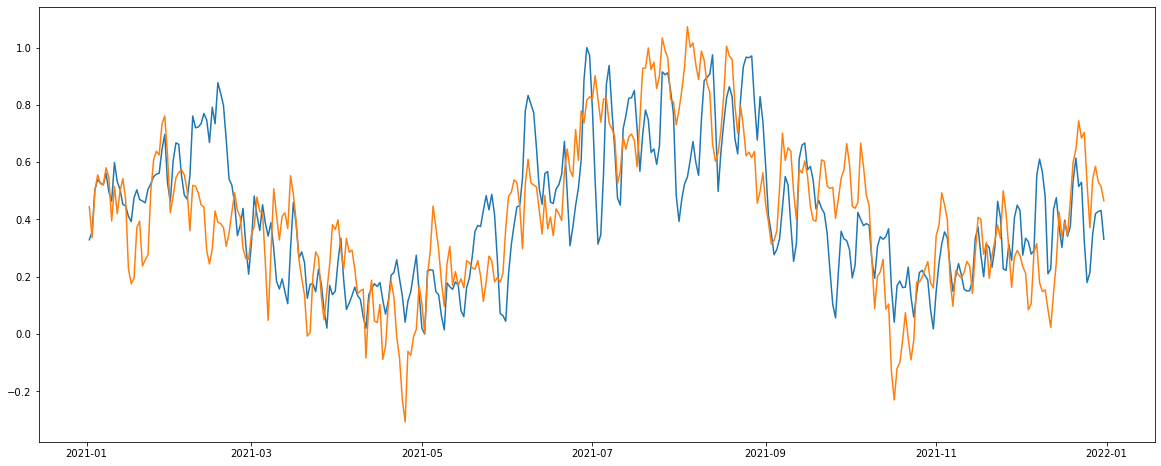

In [77]:
non_renewables_mean = np.mean(y_non_renewables)
non_renewables_var = np.var(y_non_renewables)
print(non_renewables_mean, non_renewables_var)

plt.plot(data['timestamps'], y_non_renewables)
plots = 1
for _ in range(plots):
    pred = np.array([np.random.normal(non_renewables_mean, non_renewables_var)])
    for day in x:
        input = np.concatenate((day.reshape(1,-1), np.array([pred[-1]]).reshape(1, 1)), axis=1)
        y = model_nr.posterior_samples(input, size=1)[0]
        pred = np.append(pred, y)
    plt.plot(data['timestamps'], pred[1:])
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.show()

0.3995799217871033 0.05011670130713224


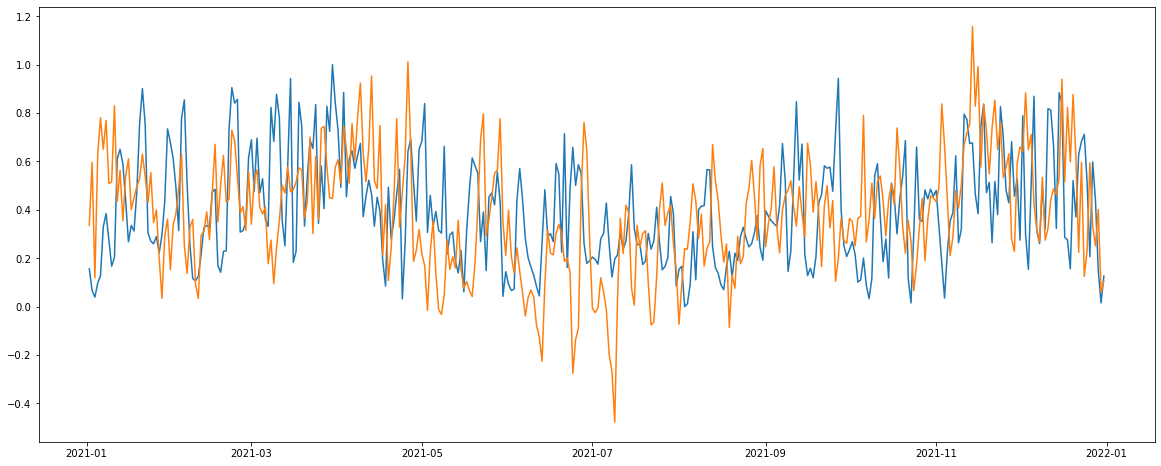

In [78]:
renewables_mean = np.mean(y_renewables)
renewables_var = np.var(y_renewables)
print(renewables_mean, renewables_var)

plt.plot(data['timestamps'], y_renewables)
plots = 1
for _ in range(plots):
    pred = np.array([np.random.normal(renewables_mean, renewables_var)])
    for day in x:
        input = np.concatenate((day.reshape(1,-1), np.array([pred[-1]]).reshape(1, 1)), axis=1)
        y = model_r.posterior_samples(input, size=1)[0][0][0]
        pred = np.append(pred, y)
    plt.plot(data['timestamps'], pred[1:])
fig = plt.gcf()
fig.set_size_inches(20, 8)
plt.show()

## Save model

In [71]:
import pickle
with open('supply-model-non-ren.pkl', 'wb') as file:
    pickle.dump(model_nr, file)
with open('supply-model-ren.pkl', 'wb') as file:
    pickle.dump(model_r, file)